#### <center> Example of pMCMC on Simulated Data

This notebook provides an example of how the API functions and how to run both the particle filter and pMCMC on simulated data from an SIRHS model. 
The packages numpy, numba, matplotlib, pandas, and jsonpickle are required for plotting and data extraction from the csv files and json dictionaries in the repo. 


In [9]:
import sys
sys.path.append('../')

#imports from PyPI
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import pandas as pd
import jsonpickle

#Code from this repo
from particle_filter import particlefilter
from pmcmc import particlemcmc
from math_utils import nbinom_logpmf,norm_logpmf,beta_logpdf,uniform_logpdf

In [10]:
'''The following lines extract the observation data, the state variables, and the trajectory of beta from csvs.
   The data is generated in another jupyter notebook, generative_data_OU_SIRH.ipynb. '''

data = pd.read_csv('../data_sets/ou_SIRH_data_nbinom.csv').to_numpy()
state = pd.read_csv('../data_sets/ou_SIRH_state_nbinom.csv').to_numpy()
betas = pd.read_csv('../data_sets/ou_SIRH_betas_nbinom.csv').to_numpy()

In [11]:
def SIRH_model(particles,observations,t,dt,model_params,rng):
    '''Definition of the SIRHS model as used in the pf algorithm. 
    '''
    hosp,R,mu,sig = model_params #Parameters to be estimated are in the model_params vector. 

    #Fixed parameters are treated as fixed constants. 
    lam = 1/14
    L = 1/90
    D = 1/7
    gamma = 1/1000

    A = np.exp(-lam * dt)
    M = mu * (np.exp(-lam * dt) - 1)
    C = sig * np.sqrt(1 - np.exp(-2 * lam * dt))

    '''Tau leaping. The setup is flexible to whatever numerical scheme the user prefers, but the timestep dt must be fixed.
    That is, adaptive methods do not work at present.'''

    for index in range(particles.shape[0]):

        '''The loop over the particles is setup as it is to allow the model function to be jit compiled in numba. 
        Unfortunately numba can't jit compile the poisson random variable generation with a vector mean. 
        '''

        new_S = rng.poisson((L * particles[index,3,t]) * dt)
        new_I = rng.poisson((particles[index,4,t] * (particles[index,0,t] * particles[index,1,t])/np.sum(particles[index,:,t])) * dt)
        new_IH = rng.poisson((D * gamma * particles[index,1,t]) * dt)
        new_HR = rng.poisson((hosp * particles[index,2,t]) * dt)
        new_IR = rng.poisson((D *(1 - gamma) * particles[index,1,t]) * dt)

        particles[index,0,t] = np.maximum(0.,particles[index,0,t] + new_S - new_I)
        particles[index,1,t] = np.maximum(0.,particles[index,1,t] + new_I - (new_IH + new_IR))
        particles[index,2,t] = np.maximum(0.,particles[index,2,t] + new_IH - new_HR)
        particles[index,3,t] = np.maximum(0.,particles[index,3,t] + new_HR + new_IR - new_S)

        particles[index,4,t] = np.exp(A * np.log(particles[index,4,t]) - M + C * rng.standard_normal())

        observations[index,0,t] = particles[index,2,t]

    return particles,observations

def SIRH_Obs(data_point, particle_observations, model_params):
    '''The observation distribution. This returns the weights which use a log scale.'''
    r = 1/model_params[1]
    weights = nbinom_logpmf(x = data_point,p = r/(r + particle_observations[:,0] + 0.005),n = np.array([r]))
    return weights


In [12]:
'''True parameter values'''
rng = np.random.default_rng(0)

'''unpickle parameter sets'''
with open("../param_sets/SIRH_OU_model_params.json", "r+") as f:
    SIRS_model_json = f.read()
    SIRS_model_params = jsonpickle.decode(SIRS_model_json)

gamma = SIRS_model_params['gamma']
R = SIRS_model_params['R']
D = SIRS_model_params['D']
hosp = SIRS_model_params['hosp']

with open("../param_sets/SIRH_OU_process_params.json", "r+") as f:
    OU_process_json = f.read()
    SIRS_OU_process_params = jsonpickle.decode(OU_process_json)

mean_ou = SIRS_OU_process_params['mean_ou']
sig = SIRS_OU_process_params['sig']

T = 250
dt = 0.1
t_vec = np.arange(0,T,dt)

def SIRH_init(num_particles, model_dim, rng):
    '''This function is used to initialize the particles at time 0.'''
    particles_0 = np.zeros((num_particles,model_dim))
    particles_0[:,0] = 1_000_000
    I_init = rng.integers(50,200,size = (num_particles))
    particles_0[:,0] -= I_init
    particles_0[:,1] = I_init
    particles_0[:,4] = rng.uniform(0.0,0.5, size = (num_particles,))
    

    return particles_0

pf_params = {'num_particles':10_000, 
                      'dt':dt,
                      'model':SIRH_model,
                      'observation_model':SIRH_Obs,
                      'model_dim':5,
                      'particle_initializer':SIRH_init,
                      }

from time import perf_counter

t = perf_counter()
output = particlefilter(data = data,
        model_params= (hosp,1/R,mean_ou,sig),
        pf_params = pf_params,
        rng = rng,
        req_jit=True
        )

print(perf_counter() - t)

17.622159608999937


 Log Likelihood : -901.2448324753494
Root Mean Squared Error for the Data 63.08757759952617


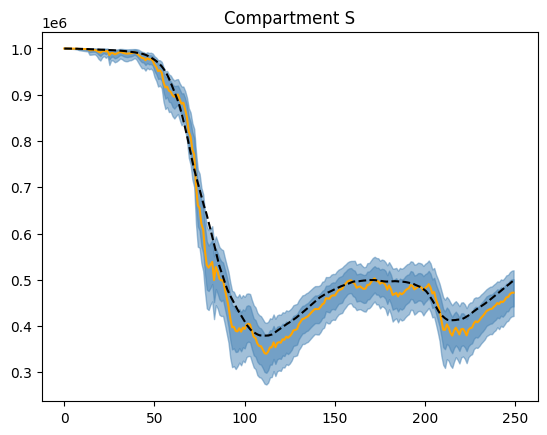

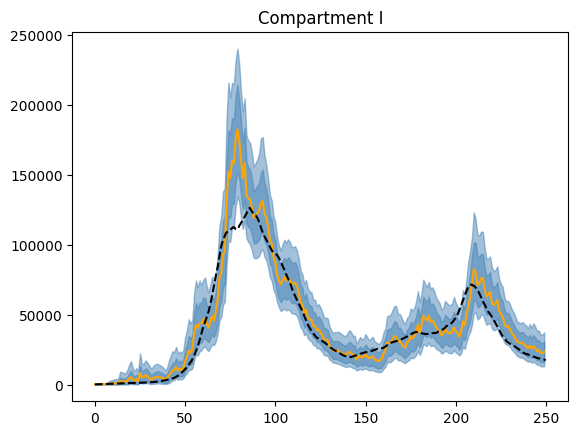

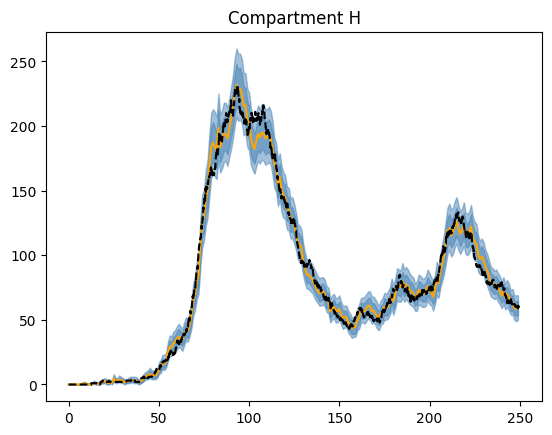

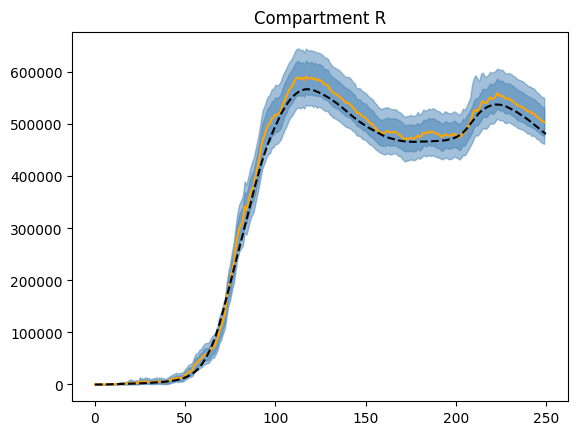

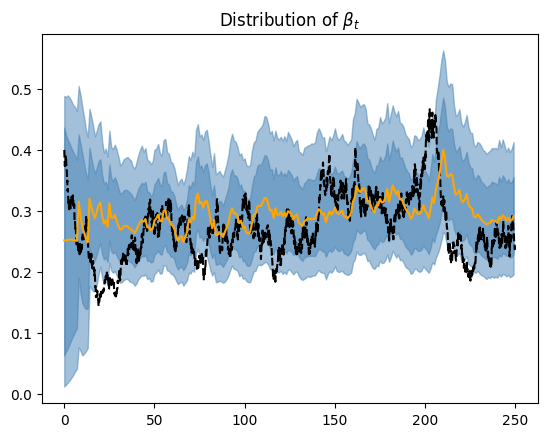

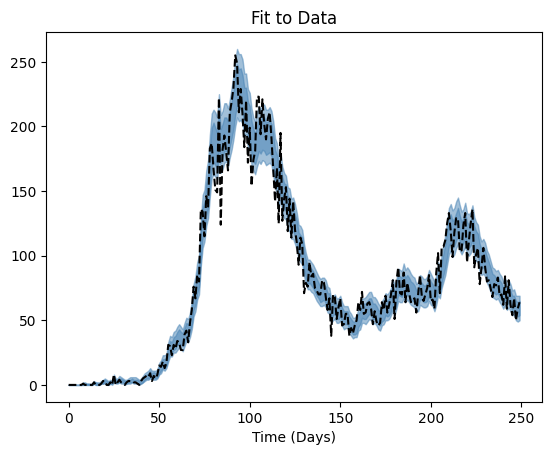

In [13]:
print(f" Log Likelihood : {np.sum(output['Log_likelihood'])}")

print(f"Root Mean Squared Error for the Data {np.sqrt(np.mean((data - np.mean(output['particle_observations'][:,0,:]))**2))}")

labels = ['S','I','H','R']
for i in range(4):
    plt.title(f'Compartment {labels[i]}')
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,2.5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,12.5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
    plt.plot(np.average(output['particle_distribution'][:,i,:],weights = np.exp(output['log_weights']),axis = 0),color = 'orange')
    plt.plot(t_vec,state[i,:].T,'--',color = 'black')
    plt.show()

plt.title('Distribution of $\\beta_t$')
plt.plot(t_vec,betas,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,4,:].T,2.5,axis = 1),np.percentile(output['particle_distribution'][:,4,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,4,:].T,12.5,axis = 1),np.percentile(output['particle_distribution'][:,4,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.plot(np.average(output['particle_distribution'][:,4,:],weights = np.exp(output['log_weights']),axis = 0),color = 'orange')
plt.show()

plt.title("Fit to Data")
plt.xlabel('Time (Days)')
plt.plot(t_vec[::int(1/dt)],data.T,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,2.5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,12.5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.show()

In [14]:
pmcmc_rng = np.random.default_rng(10)

def sirh_prior(theta):
    return uniform_logpdf(theta[0],min_val= 0.,max_val= 0.3) + \
    uniform_logpdf(theta[1],min_val = 1/1000.,max_val = 1/5.) + \
    norm_logpmf(theta[2],mu = -0.8,sig = 0.4) + \
    beta_logpdf(theta[3],alpha = 1.,beta = 1.)


'''estimated params hosp,D,R,mean_ou,sig'''

pmcmc_params = {'iterations':10_000,
                'init_params':np.array([0.1,0.1,-1.,0.01]),
                'prior':sirh_prior,
                'init_cov':  np.diag([0.001,0.001,0.001,0.001]),
                'burn_in':1_000}

pf_params = {'num_particles':1000, 
                      'dt':1.,
                      'model':SIRH_model,
                      'observation_model':SIRH_Obs,
                      'model_dim':5,
                      'particle_initializer':SIRH_init
                      }

t = perf_counter()
pmcmc_output = particlemcmc(
                  data = data,
                  pmcmc_params=pmcmc_params,
                  pf_params=pf_params,
                  adaptive=True,
                  rng = rng,
                  req_jit=True
                  )
print(perf_counter() - t)

iteration: 10| Acceptance rate: 0.3| Log-Likelihood: -978.6011247027674| Proposal [ 0.08004081  0.05774041 -1.13358392  0.01361333]
iteration: 20| Acceptance rate: 0.2| Log-Likelihood: -977.1648952550111| Proposal [ 0.05530763  0.01732784 -1.09942885  0.0120722 ]
iteration: 30| Acceptance rate: 0.16666666666666666| Log-Likelihood: -930.0183645866958| Proposal [ 0.06782761  0.02205992 -1.12693367  0.03852147]
iteration: 40| Acceptance rate: 0.125| Log-Likelihood: -930.0183645866958| Proposal [ 0.06782761  0.02205992 -1.12693367  0.03852147]
iteration: 50| Acceptance rate: 0.12| Log-Likelihood: -911.7043697723549| Proposal [ 0.0662603   0.01234424 -1.05335671  0.10058941]
iteration: 60| Acceptance rate: 0.11666666666666667| Log-Likelihood: -908.7889519889176| Proposal [ 0.08650991  0.01970075 -1.04080478  0.15830356]
iteration: 70| Acceptance rate: 0.1| Log-Likelihood: -908.7889519889176| Proposal [ 0.08650991  0.01970075 -1.04080478  0.15830356]
iteration: 80| Acceptance rate: 0.1| Log-

-896.5130140561504
The Maximum Likelihood Estimate is [ 0.07648916  0.00876356 -1.24206339  0.25823299] w/ LL of -896.5130140561504


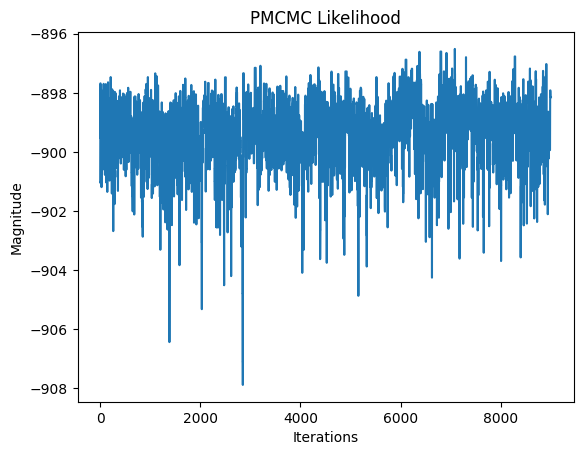

In [20]:
burn_in = 1_000

MLE = np.argmax(pmcmc_output['Log Likelihood'])

print(pmcmc_output['Log Likelihood'][MLE])

print(f"The Maximum Likelihood Estimate is {pmcmc_output['accepted_params'][:,MLE]} w/ LL of {pmcmc_output['Log Likelihood'][MLE]}")

plt.title("PMCMC Likelihood")
plt.ylabel("Magnitude")
plt.xlabel("Iterations")
plt.plot(pmcmc_output['Log Likelihood'][burn_in:])

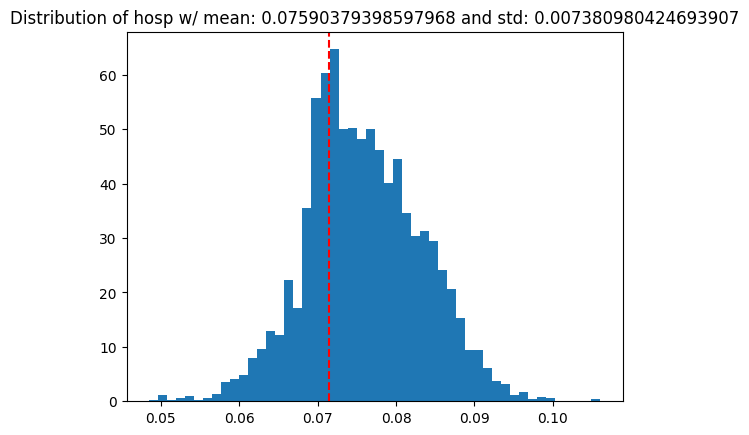

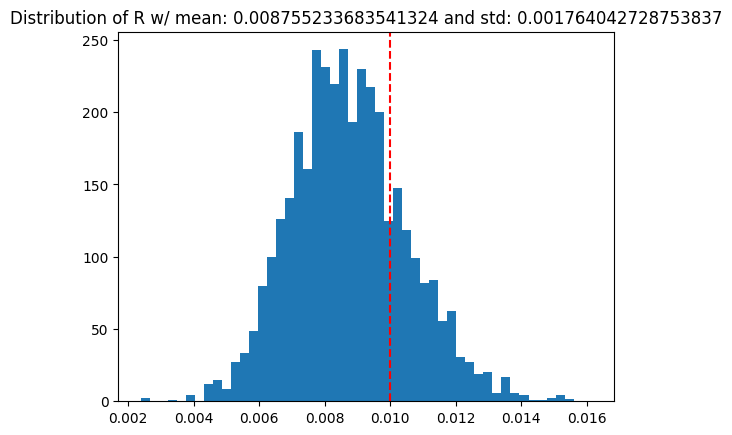

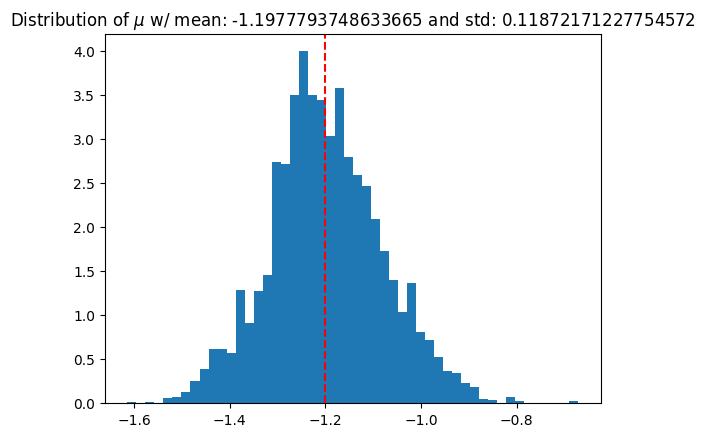

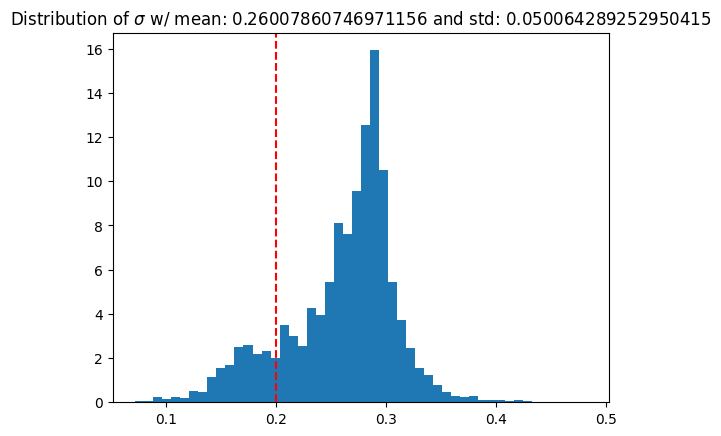

In [22]:
plt.title(f"Distribution of hosp w/ mean: {np.mean(pmcmc_output['accepted_params'][0,burn_in:])} and std: {np.std(pmcmc_output['accepted_params'][0,burn_in:])}")
plt.hist(pmcmc_output['accepted_params'][0,burn_in:],density=True,bins = 50)
plt.axvline(x=hosp, color='r', linestyle='--') 
plt.show()

plt.title(f"Distribution of R w/ mean: {np.mean((pmcmc_output['accepted_params'][1,burn_in:]))} and std: {np.std((pmcmc_output['accepted_params'][1,burn_in:]))}")
plt.hist((pmcmc_output['accepted_params'][1,burn_in:]),density=True,bins = 50)
plt.axvline(x=1/R, color='r', linestyle='--') 
plt.show()

plt.title(f"Distribution of $\\mu$ w/ mean: {np.mean((pmcmc_output['accepted_params'][2,burn_in:]))} and std: {np.std((pmcmc_output['accepted_params'][2,burn_in:]))}")
plt.hist((pmcmc_output['accepted_params'][2,burn_in:]),density=True,bins = 50)
plt.axvline(x=mean_ou, color='r', linestyle='--') 
plt.show()

plt.title(f"Distribution of $\\sigma$ w/ mean: {np.mean((pmcmc_output['accepted_params'][3,burn_in:]))} and std: {np.std((pmcmc_output['accepted_params'][3,burn_in:]))}")
plt.hist((pmcmc_output['accepted_params'][3,burn_in:]),density=True,bins = 50)
plt.axvline(x=sig, color='r', linestyle='--') 
plt.show()


In [23]:
par = np.mean((pmcmc_output['accepted_params'][:,burn_in:]),axis = 1)

pf_params = {'num_particles':10_000, 
                      'dt':dt,
                      'model':SIRH_model,
                      'observation_model':SIRH_Obs,
                      'model_dim':5,
                      'particle_initializer':SIRH_init,
                      }

from time import perf_counter

t = perf_counter()
output = particlefilter(data = data,
        model_params= par,
        pf_params = pf_params,
        rng = rng,
        req_jit=True
        )

print(perf_counter() - t)

17.487373146999744


 Log Likelihood : -901.3359968090961
Root Mean Squared Error for the Data 63.081325105405


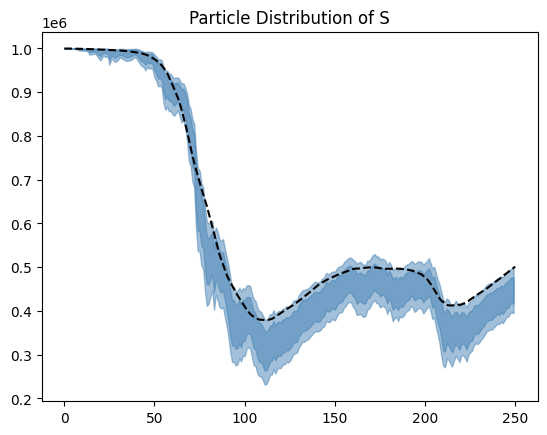

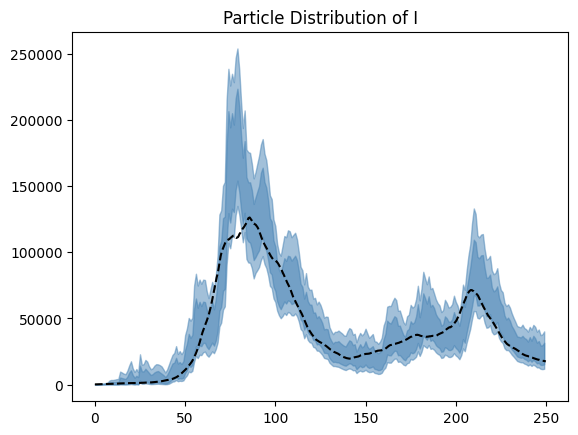

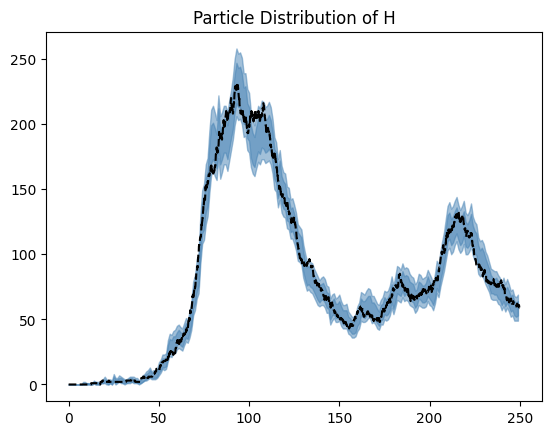

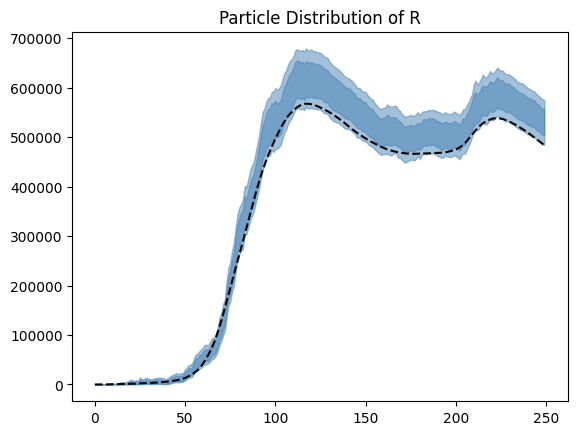

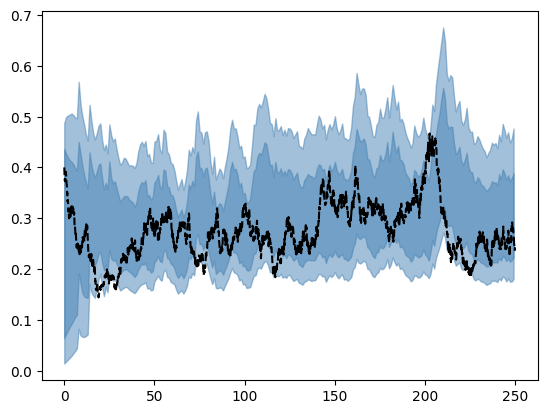

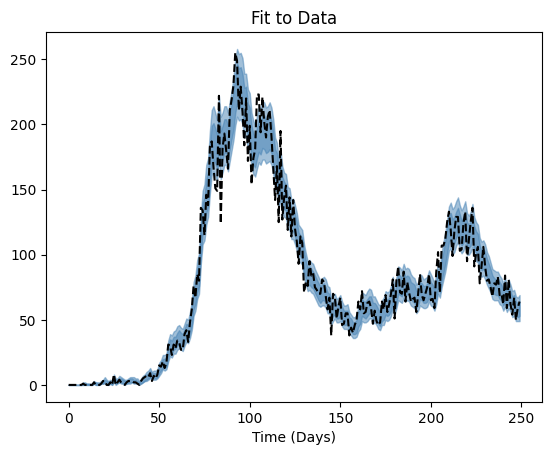

In [24]:
'''Plots using the Expectation of the parameters and running the filter. '''
print(f" Log Likelihood : {np.sum(output['Log_likelihood'])}")
print(f"Root Mean Squared Error for the Data {np.sqrt(np.mean((data - np.mean(output['particle_observations'][:,0,:]))**2))}")

dt = pf_params['dt']
Labels = ['S','I','H','R']
for i in range(4):
    plt.title(f"Particle Distribution of {Labels[i]}")
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,2.5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,12.5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
    plt.plot(t_vec,state[i,:].T,'--',color = 'black')
    plt.show()

plt.plot(t_vec,betas,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,4,:].T,2.5,axis = 1),np.percentile(output['particle_distribution'][:,4,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,4,:].T,12.5,axis = 1),np.percentile(output['particle_distribution'][:,4,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.show()

plt.title("Fit to Data")
plt.xlabel('Time (Days)')
plt.plot(t_vec[::int(1/dt)],data.T,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,2.5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,12.5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.show()

In [26]:
'''The output of pMCMC is stored in npz files. This file format stores numpy arrays in 
a dictionary style to be accessed later. '''

np.savez('../pmcmc_output/SIRH_pmcmc_output.npz',
accepted_params = pmcmc_output['accepted_params'],
log_likelihood=pmcmc_output['Log Likelihood'],
MLE_particle_dist = pmcmc_output['MLE_particle_dist'],
MLE_particle_observations = pmcmc_output['MLE_particle_observations'])